I've retooled some things to make the lnPi exptropolation a bit more convenient

1)  Added functions to extrapolate on Just energy $u,u^n, \delta^n u$.
This may be overkill, but it greatly simplifies life if all you want is to extrapolate energy, and only
have pre-computed averages as opposed to raw data
   
2)  To Handle the energy only expansion, I've retooled the Data classes.  If you pass `xv=None`, then it is assumed
that `xv = uv`. Additionally, there is a bool parameter `x_is_u`.  If this True, then adjust the properties `self.u`, `self.du`, etc.  Also, this adjust constructors like `DataCentralMoments.from_ave_raw` to accept only moments of `u`
and adjust accordingly.  

3) Retooled the `meta` parameter in Data classes.  Instead of passing a dict, you now (optionally) pass in a class (or subclass) of DataCallback.  In this class, you can adjust things like `self.deriv_args`, `self.resample`, etc.
See `xpan_vol` for an example.

4) Used all this to do lnPi extrapolation


In [1]:
import numpy as np
import xarray as xr

import thermoextrap.xtrapy as xtrapy
import thermoextrap.xtrapy.xpan_beta as xpan_beta
import thermoextrap.xtrapy.xpan_lnPi as xpan_lnPi

# sympy functions for energy

In [2]:
def list_derivs(exprs, seq=4, subs=None):
    if isinstance(seq, int):
        seq = range(seq)
    
    out = [exprs[i] for i in seq]
    if subs is not None:
        out = [x.subs(subs) for x in out]
    return out

In [3]:
dxdu, du = xpan_beta._get_default_indexed('dxdu','du')
x1, u = xpan_beta._get_default_symbol('x1','u')

seq = range(5)
subs = {dxdu[i]: du[i+1] for i in seq}
subs[x1] = u


x_deriv = xpan_beta.factory_derivatives(name='x_ave', central=True)
u_deriv = xpan_beta.factory_derivatives(name='u_ave', central=True)

# x derivatives without subs
print('no subs')
print(list_derivs(x_deriv.exprs, seq=seq))
print('subs')
print(list_derivs(x_deriv.exprs, seq=seq, subs=subs))
print('u')
print(list_derivs(u_deriv.exprs, seq=seq))


no subs
[x1, -dxdu[1], dxdu[2], 3*du[2]*dxdu[1] - dxdu[3], -6*du[2]*dxdu[2] - 4*du[3]*dxdu[1] + dxdu[4]]
subs
[u, -du[2], du[3], 3*du[2]**2 - du[4], -10*du[2]*du[3] + du[5]]
u
[u, -du[2], du[3], 3*du[2]**2 - du[4], -10*du[2]*du[3] + du[5]]


$\newcommand{\ave}[1]{{\langle #1 \rangle}}$
The following are avialable for `name`
* `x_ave` : central or raw expansion of $\ave{x}$
* `u_ave` : central or raw expansion of $\ave{u}$
* `dun_ave` : central expansion of $\ave{(\delta u)^n}$
* `dxdun_ave` : central expansion of $\ave{dx  (\delta u)^n}$
* `un_ave` : raw expansion of $\ave{u^n}$
* `xun_ave`: raw expansion of $\ave{x u^n}$


In [4]:
f = xpan_beta.factory_derivatives(name='dun_ave', n=2)
print(list_derivs(f.exprs, seq=seq))

[du[2], -du[3], -3*du[2]**2 + du[4], 10*du[2]*du[3] - du[5], 30*du[2]**3 - 15*du[2]*du[4] - 10*du[3]**2 + du[6]]


I've tested all the `u` derivative expressions against the `xu` versions.  See tests/test_u_equations.py.

If x=u, then $x u^n$ = $u^{n+1}$.  So need to adjust things in Data classes if want to use energy expansion

## post_func

I've also changed how `minus_log` works.  You can still apply it in the Derivatives class, which takes the base derivatives and converts them.  However, to be more general, SymDerivsBeta Take an argument `post_func`.  This can be a callable or a string. String values are `post_func='minus_log'` and `post_func='pow_i'`, (i=2,3,...).

In [27]:
f_u = xpan_beta.factory_derivatives('u_ave')

# can also use post_func = lambda x: -sympy.log(x) for same effect
f_logu = xpan_beta.factory_derivatives('u_ave', post_func='minus_log')
print(list_derivs(f_u.exprs, seq=range(3)))
print(list_derivs(f_logu.exprs, seq=range(3)))


[u[1], u[1]**2 - u[2], 2*u[1]**3 - 3*u[1]*u[2] + u[3]]
[-log(u[1]), -u[1] + u[2]/u[1], -u[1]**2 + u[2] - u[3]/u[1] + u[2]**2/u[1]**2]


# Rework data classes

Now that we have expressions for the derivatives of $u$, how do we pass in data for them?  

In [28]:
def do_testing(attrs, obj0, obj1, **kwargs):
    for attr in attrs:
        val0, val1 = [getattr(obj, attr) for obj in (obj0, obj1)]
        val1 = val1.transpose(*val0.dims)
        np.testing.assert_allclose(val0, val1, **kwargs)

def do_testing_gen(central=False, *args, **kwargs):
    if central:
        attrs = ['du','dxdu','xave']
    else:
        attrs = ['u','xu']
        
    return do_testing(attrs, *args, **kwargs)
        

In [29]:
def get_data(u, central=False, order=5, style='factory'):

    # pass in x = u
    # xv = None => xv = u
    if style == 'factory':
        factory = xpan_beta.factory_data
    elif style == 'central':
        factory = xtrapy.DataCentralMoments.from_vals
    elif style == 'central_vals':
        factory = xtrapy.DataCentralMomentsVals.from_vals
    
    data_x = factory(uv=u, xv=u, x_is_u=False, order=order, central=central)

    # pass in 
    data_u = factory(uv=u, xv=None, x_is_u=True, order=order, central=central)
    
    return data_x, data_u


In [30]:
n = 2000
u = np.random.rand(n)
order = 5

data_x, data_u = get_data(central=False, u=u)

# note that data_u.u has an extra moment.  This comes from xu**n = u**(n+1)
print(data_x.u)
print(data_u.u)

<xarray.DataArray 'u' (umom: 6)>
array([1.        , 0.49458167, 0.32871062, 0.24598479, 0.19623161,
       0.16295016])
Dimensions without coordinates: umom
<xarray.DataArray 'u' (umom: 7)>
array([1.        , 0.49458167, 0.32871062, 0.24598479, 0.19623161,
       0.16295016, 0.13910304])
Coordinates:
  * umom     (umom) int64 0 1 2 3 4 5 6


In [31]:
# these are the same
print(data_x.xu)
print(data_u.xu)

<xarray.DataArray 'x' (umom: 6)>
array([0.49458167, 0.32871062, 0.24598479, 0.19623161, 0.16295016,
       0.13910304])
Dimensions without coordinates: umom
<xarray.DataArray 'u' (umom: 6)>
array([0.49458167, 0.32871062, 0.24598479, 0.19623161, 0.16295016,
       0.13910304])
Dimensions without coordinates: umom


In [32]:
# differnet derivs_args in this case
print(data_x.derivs_args)
print(data_u.derivs_args)

(<xarray.DataArray 'u' (umom: 6)>
array([1.        , 0.49458167, 0.32871062, 0.24598479, 0.19623161,
       0.16295016])
Dimensions without coordinates: umom, <xarray.DataArray 'x' (umom: 6)>
array([0.49458167, 0.32871062, 0.24598479, 0.19623161, 0.16295016,
       0.13910304])
Dimensions without coordinates: umom)
(<xarray.DataArray 'u' (umom: 7)>
array([1.        , 0.49458167, 0.32871062, 0.24598479, 0.19623161,
       0.16295016, 0.13910304])
Coordinates:
  * umom     (umom) int64 0 1 2 3 4 5 6,)


In [33]:
# testing classes
for central in [False, True]:
    data_x, data_u = get_data(central=central, u=u)

    data_x_c, data_u_c = get_data(central=central, style='central', u=u)
    data_x_v, data_u_v = get_data(central=central, style='central_vals', u=u)

    do_testing_gen(central, data_x, data_x_c)
    do_testing_gen(central, data_u, data_u_c)
    do_testing_gen(central, data_x, data_x_v)
    do_testing_gen(central, data_u, data_u_v)

    # do expansion
    beta = 1.0
    betas = [0.5, 1.5]

    em_x = xpan_beta.factory_extrapmodel(beta=beta, data=data_x, name='x_ave')
    em_u = xpan_beta.factory_extrapmodel(beta=beta, data=data_u, name='u_ave')
    np.testing.assert_allclose(em_x.predict(betas, cumsum=True), em_u.predict(betas, cumsum=True))
    
    for d in [data_u_v, data_u_c]:
        em_v = xpan_beta.factory_extrapmodel(beta=beta, data=d, name='u_ave')
        np.testing.assert_allclose(em_x.predict(betas, cumsum=True), em_v.predict(betas, cumsum=True))
        



In [58]:
# back to minus_log
import sympy as sp
for d, name in [(data_x, 'x_ave'), (data_u, 'u_ave')]:
    em_ref =  xpan_beta.factory_extrapmodel(beta=beta, data=d, name=name)

    em_log = [
        xpan_beta.factory_extrapmodel(beta=beta, data=d, name=name, post_func='minus_log'),
        xpan_beta.factory_extrapmodel(beta=beta, data=d, name=name, post_func=lambda x: -sp.log(x)),
    ]

    # if using bare funciton, have to pass minus_log to predict method
    out_ref = em_ref.predict(betas, cumsum=True, minus_log=True)
    for em in em_log:
        np.testing.assert_allclose(out_ref, em.predict(betas, cumsum=True))

## This also applies to higher moments

## <u**2>

In [87]:
central = False
order = 5
data_x2 = xtrapy.DataCentralMomentsVals.from_vals(uv=u, xv=u**2, central=central, order=order)
# have to use raw moments here.
data_u = xtrapy.DataCentralMomentsVals.from_vals(uv=u, xv=None, x_is_u=True, central=central, order=order)

In [88]:
beta = 1.0
em_x2 = xpan_beta.factory_extrapmodel(beta=beta, data=data_x2, name='x_ave', order=order-1)
em_u2 = xpan_beta.factory_extrapmodel(beta=beta, data=data_u, name='un_ave', n=2, order=order-1)

In [89]:
betas = np.random.rand(4)

In [90]:
a = em_x2.predict(betas, cumsum=True)
b = em_u2.predict(betas, cumsum=True)
np.testing.assert_allclose(a, b)

## <du**2>

NOTE: to relate the predicted value of <du**n> to <u**n> ...., have to be smart about stuff

In [101]:
em_u1_sq = xpan_beta.factory_extrapmodel(beta=beta, data=data_u, name='un_ave', n=1, post_func='pow_2', order=order-1)
em_du2 = xpan_beta.factory_extrapmodel(beta=beta, data=data_u.assign_params(central=True), name='dun_ave', n=2, order=order-1)

In [141]:
out_du2 = em_du2.predict(betas, cumsum=True)

#<du**2> = <u**2> - <u>**2
out_u2 = em_u2.predict(betas, cumsum=True)
out_u1_sq = em_u1_sq.predict(betas, cumsum=True)

np.testing.assert_allclose(out_du2, out_u2 - out_u1_sq)

In [142]:
#if we naively try the following, we will fail...

em_u1 = xpan_beta.factory_extrapmodel(beta=beta, data=data_u, name='un_ave', n=1, order=order-1)

out_u1 = em_u1.predict(betas, cumsum=True)

np.testing.assert_allclose(out_du2, out_u2 - out_u1**2)


AssertionError: 
Not equal to tolerance rtol=1e-07, atol=0

Mismatched elements: 12 / 20 (60%)
Max absolute difference: 0.00605186
Max relative difference: 0.07733669
 x: array([[0.0841  , 0.084184, 0.083553, 0.083552, 0.083556],
       [0.0841  , 0.084305, 0.080587, 0.080574, 0.080704],
       [0.0841  , 0.084113, 0.084097, 0.084097, 0.084097],
       [0.0841  , 0.084242, 0.08245 , 0.082446, 0.082476]])
 y: array([[0.0841  , 0.083156, 0.083552, 0.083557, 0.083556],
       [0.0841  , 0.078253, 0.080572, 0.080752, 0.080703],
       [0.0841  , 0.084087, 0.084097, 0.084097, 0.084097],
       [0.0841  , 0.081325, 0.082445, 0.082487, 0.082476]])

In [154]:
#To fix this, have to handle products correctly

# skip summing
out_u1 = em_u1.predict(betas, no_sum=True)

out_u1u1 = (
    (out_u1.rename(order='order_a') * out_u1.rename(order='order_b'))
    .assign_coords(order=lambda x: x['order_a'] + x['order_b'])
    .groupby('order')
    .sum()
    .reindex(order=out_u2.order)
    .cumsum('order')
    
)

np.testing.assert_allclose(out_du2, out_u2 - out_u1u1)

# lnPi extrapolation

In [155]:
import thermoextrap.xtrapy.xpan_lnPi as xpan_lnPi

In [159]:
fr = xpan_lnPi.factory_derivatives(name='lnPi', central=False)
print(list_derivs(fr.exprs, range(4)))

fc = xpan_lnPi.factory_derivatives(name='lnPi', central=True)
print(list_derivs(fc.exprs, range(4)))

[lnPi0, mudotN - u[1], -u[1]**2 + u[2], -2*u[1]**3 + 3*u[1]*u[2] - u[3]]
[lnPi0, mudotN - u, du[2], -du[3]]


## expansion
tl;dr version

In [175]:
import json

def sample_data():

    with open('../tests/lnpi_data/sample_data.json', 'r') as f:
        d = json.load(f)

    ref, samples = d['ref'], d['samples']
#    return ref, samples
    for x in [ref] + samples:
        # cleanup data
        x['lnPi'] = np.array(x['lnPi'])
        x['energy'] = np.array(x['energy'])


    return ref, samples


def prepare_data(lnPi, energy, mu, temp, order, beta):
    beta = 1.0 / temp
    mu = xr.DataArray(np.atleast_1d(mu), dims=['comp'])
    
    lnPi = xr.DataArray(lnPi, dims=['n'])
    
    # adjust lnPi to have lnPi[n=0] = 0
    lnPi = lnPi - lnPi.sel(n=0)

    # have to include mom = 0
    a = np.ones_like(lnPi)
    energy = np.concatenate((a[:, None], energy), axis=-1)
    energy = xr.DataArray(energy, dims=['n','umom'])
    
    return {'lnPi': lnPi, 'energy': energy, 'mu': mu, 'beta': beta, 'order': order, 'temp': temp}
    


ref, samples = sample_data()

ref = prepare_data(**ref)
samples = [prepare_data(**d) for d in samples]

In [176]:
# for energy extrapolation, use the following
data_u = xtrapy.DataCentralMoments.from_ave_raw(u=ref['energy'], xu=None, x_is_u=True, central=True, meta=None)
em_u = xpan_beta.factory_extrapmodel(beta=ref['beta'], data=data_u, name='u_ave')

In [177]:
# for lnPi extrapolation, we need to setup a DataCallback
# see definition in xpan_lnPi
# this callback class will adjust things in 
meta_lnpi = xpan_lnPi.lnPiDataCallback(ref['lnPi'], ref['mu'], dims_n=['n'], dims_comp='comp')
# add in meta_lnpi
data_lnpi = data_u.new_like(meta=meta_lnpi)


em_lnpi = xpan_lnPi.factory_extrapmodel_lnPi(beta=ref['beta'], data=data_lnpi)

betas = np.unique([x['beta'] for x in samples])
temps = np.round(1. / betas, 3)

In [178]:
out_lnpi = (
    em_lnpi.predict(betas, cumsum=True)
    .pipe(lambda x: x - x.sel(n=0))
    .assign_coords(temp = lambda x: np.round(1. / x['beta'], 3))
)

out_u = em_u.predict(betas, cumsum=True)


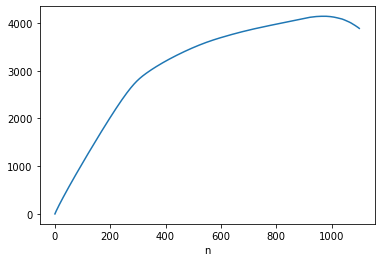

In [181]:
meta_lnpi.lnPi0.plot()

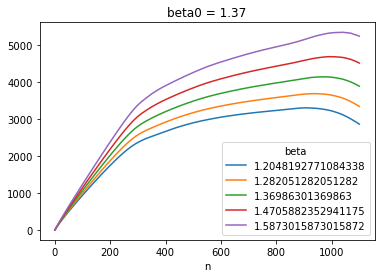

In [184]:
out_lnpi.sel(order=1).plot(hue='beta')

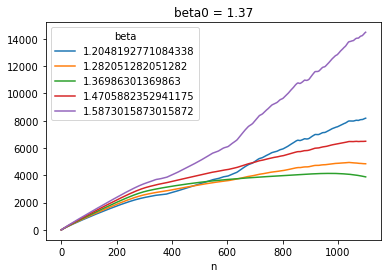

In [185]:
out_lnpi.sel(order=2).plot(hue='beta')

In [186]:
# test against known results
for s in samples:
    

    a = s['lnPi']
    b = out_lnpi.sel(beta=s['beta'], order=s['order'])
    np.testing.assert_allclose(a, b)
    
    # test energies:
    a = s['energy'].sel(umom=1)
    b = out_u.sel(beta=s['beta'], order=s['order'])
    np.testing.assert_allclose(a, b, rtol=1e-5)
